### We have different dataframes: 

1. **Spotify_600**: all tracks and features associated to tracks, from this dataframe we delete the non-music songs
2. **artists_600**: all artists and a small number of features related to the artists
3. **feat_track_600**: all songs with more than one artist, since 1999 (passed to create nodes_600)
4. **nodes_600**: edge lists from source to target, including number of features and songs in which they collaborated
5. **artists_600_features**: artist features, popularity and song features for all songs
6. **genres**: all genres with the number of artists having that genre

In [377]:
import pandas as pd
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as ntx
import re
import random
from sklearn.manifold import TSNE
import math
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# ref doc https://github.com/eliorc/node2ve and https://towardsdatascience.com/node2vec-embeddings-for-graph-data-32a866340fef
from node2vec import Node2Vec 
from sklearn.model_selection import train_test_split
from music_utils import *
from tqdm.auto import tqdm  # import tqdm for progress bar
tqdm.pandas()
from gensim.models import Word2Vec


from sklearn import preprocessing
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.utils.class_weight import compute_sample_weight

import torch
from torch import nn
from torch_geometric.nn import GCNConv
import torch.nn.functional as F


In [2]:
local = True
if local:
    DATA_PATH = '../data/'
else:
    DATA_PATH = './data/'

In [3]:
def graph_largest_cc(nodes_df, plot_graph=False, write_graphml=None):   
    edge_list = [tuple(l[:2]) for l in nodes_df.values.tolist()]
    G = ntx.from_edgelist(edge_list)
    largest_cc = G.subgraph(max(ntx.connected_components(G), key=len))
    print(f'The largest connected component has {len(largest_cc.nodes)} nodes.')
    print(f'The largest connected component has {len(largest_cc.edges)} edges.')

    if plot_graph:
        fig, ax = plt.subplots(figsize=(15, 15))
        ntx.draw_networkx(largest_cc, with_labels=False, node_size = 20, ax = ax)
        plt.show()
    
    if write_graphml != None:
        ntx.write_graphml_lxml(G, write_graphml+'.graphml')
    return G, largest_cc

Ran this once on the CSV's from the kaggle website, is now saved locally in pickle files

In [4]:
spotify_600, artists_600 = read_spotify_600(DATA_PATH=DATA_PATH, read=True)

We filter out the non-music tracks, then we create the edge lists and the features for artists. 

In [5]:
# Filter out non-music
n_non_music = sum(spotify_600["speechiness"] > 0.7)
print(f"We are deleting {n_non_music} songs from the dataframe")
spotify_600 = spotify_600[spotify_600["speechiness"] < 0.7]

We are deleting 22100 songs from the dataframe


In [6]:
#Nodes creation
feat_track_600 = spotify_600[(spotify_600.num_artists > 1)&(spotify_600.release_date.dt.year > 1999)].copy()
nodes_600 = nodes_featuring(feat_track_600, DATA_PATH=DATA_PATH, read=False, path='edge_list_600k_over1999.pkl')

In [7]:
artists_600_features = artists_features_creation(artists_600, spotify_600, DATA_PATH, read=False)

In [8]:
#Genres
genres = pd.DataFrame(artists_600_features.genres.explode().value_counts().reset_index()).dropna().rename(
    columns={'index':'genre','genres':'number_of_artists'}
)

In [9]:
edge_list = [tuple(l[:2]) for l in nodes_600.values.tolist()]
G = ntx.from_edgelist(edge_list)
largest_cc = G.subgraph(max(ntx.connected_components(G), key=len))
print(f'The largest connected component has {len(largest_cc.nodes)} nodes.')
print(f'The largest connected component has {len(largest_cc.edges)} edges.')

The largest connected component has 20500 nodes.
The largest connected component has 62429 edges.


# Node Classification

## Classification methods to try

1. Deepwalk and Node2Vec + visualisation
2. GNN
3. Classical ML on node features and structural information

For this we have to: 1) create a train val test split and 2) find what to do with NaN values

## Data preprocessing for Node Classification

The corresponding logic can be found in the utils file, but we went through a couple of steps: 

1. Make 6 overarching genres: french rap becomes rap etc., 
2. Then select artists that belong to one of these genres
3. Make sure each artist belongs to only one genre, and add the features defined before
4. Select only edges in which both the source and target belong to the artists selected in step 2
5. Return a graph and a matrix of node features 

Dates begining and date end

We now have a graph and a matrix of node features

In [10]:
graph, features = get_graph_features_node_classification(genres,artists_600,artists_600_features,nodes_600)

/Users/pieterjanmotmans/Documents/DSBA/M2/Term 2/MLNS/SpotifyProject/MLNS-Spotify/music_utils.py:314: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  artists_popular_genres['idx'] = artists_popular_genres.index


[('003f4bk13c6Q3gAUXv7dGJ', '0AeOzXbHJu8q2xqILEOLEO'), ('003f4bk13c6Q3gAUXv7dGJ', '0IuqAyi5CMgpuyhckrcqNs'), ('003f4bk13c6Q3gAUXv7dGJ', '0Yy8ebHB2Ubh1xVIdddNYF'), ('003f4bk13c6Q3gAUXv7dGJ', '0atCvjK2GL6ezQFGOQOYQo'), ('003f4bk13c6Q3gAUXv7dGJ', '0cxXnDhpgxcMMkKddhORHY')]


In [11]:
print(f'There are {len(graph.nodes)} nodes')
print(f' and {len(graph.edges)} edges')

There are 8762 nodes
 and 28233 edges


We will sometimes need artist id's as the artist id, sometimes as number: we make a dictionary

In [12]:
id_to_number = dict(zip(graph.nodes, list(range(len(graph.nodes)))))
number_to_id = dict(zip(list(range(len(graph.nodes))), graph.nodes))

In [13]:
features.genres_x.value_counts()

rap          3724
pop          2615
dance         908
rock          670
latin         596
classical     249
Name: genres_x, dtype: int64

In [404]:
X = features.copy()
y = X.pop('genres_x')
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 42)

In [15]:
le.classes_

array(['classical', 'dance', 'latin', 'pop', 'rap', 'rock'], dtype=object)

In [102]:
X.shape

(8762, 19)

# DeepWalk and Node2Vec

In [333]:
window = 2
dims = 5
num_walks = 5
walk_length = 20
deepwalk = DeepWalk(graph, window=window, dims=dims, num_walks=num_walks, walk_length=walk_length)
walks = deepwalk.generate_walks()
embeddings = deepwalk.skipgram()

In [358]:
embeddings_df = pd.DataFrame([embeddings[id_to_number[node]] for node in graph.nodes()])
embeddings_df['idx'] = [number_to_id[node] for node in embeddings_df.index]
embeddings_df = embeddings_df.set_index('idx')

In [326]:
embeddings

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.230280,0.190902,0.989771,-0.214733,-0.540234,-0.627658,0.377186,0.949738,0.047683,-0.398709,...,-0.046555,-0.048665,0.080344,-0.832388,0.278096,0.590342,-0.042672,-0.388876,-0.604740,-0.840586
1,0.150667,0.720622,0.759735,-0.651690,-0.467401,-0.727464,0.239880,1.424804,1.148461,-0.658608,...,-0.725017,0.107891,0.584347,0.576473,-0.027101,-0.180107,-1.763992,-0.078225,-0.138370,-0.287273
2,1.190160,-0.049279,0.043934,0.165194,-0.074693,-0.696758,0.055051,1.477074,0.303011,-0.017987,...,0.688840,0.056204,0.214725,-0.221653,-0.564275,-0.253075,-0.315124,-0.334146,-1.119460,0.320931
3,0.790685,0.534645,0.309138,0.318767,0.148730,-0.390218,-0.035239,1.288063,0.378609,0.314296,...,0.317316,0.242047,0.082680,-0.310602,-0.230723,-0.029998,-0.798860,-0.290549,-1.012266,0.051803
4,1.243091,0.192297,0.271879,0.504984,0.234325,0.148078,0.370511,0.391934,0.662926,0.006317,...,0.465758,-0.899440,-0.048416,-0.106481,-0.341193,0.160161,-0.066178,-0.584910,-0.052266,0.023266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8757,0.023620,0.025736,0.054738,-0.007317,-0.012370,0.002459,0.021338,0.040719,0.064379,0.012568,...,0.025657,-0.003820,0.017544,0.019054,-0.001429,-0.004139,-0.022772,-0.020789,-0.001924,-0.019013
8758,0.009695,0.013177,0.026433,0.000878,-0.006185,0.000091,0.010646,0.017964,0.029476,0.008535,...,0.022345,-0.003378,0.003031,0.007765,-0.000084,-0.004564,-0.005642,-0.007056,0.001398,-0.009616
8759,0.005101,0.018469,0.039669,-0.007559,-0.012549,0.002832,0.020782,0.009192,0.042747,0.009776,...,0.023002,-0.004478,0.002380,0.024391,-0.003167,-0.007589,-0.006570,-0.003896,0.019189,-0.013963
8760,0.009776,0.011798,0.026105,-0.005179,-0.009412,0.001912,0.014150,0.018949,0.029885,0.006036,...,0.015094,-0.005674,0.004944,0.008282,-0.003653,-0.001111,-0.007985,-0.008609,0.001399,-0.009284


In [17]:
visualize(graph, embeddings, y,id_to_number,labeled = True)

NameError: name 'TSNE' is not defined

Macro test F1: 0.18354654584414368
Accuracy: 0.3582430119794638


0.18354654584414368

<Figure size 432x288 with 0 Axes>

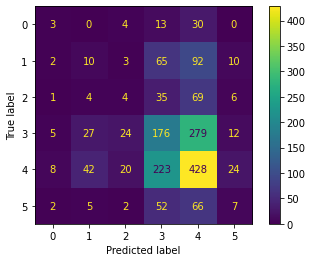

In [18]:
predict(embeddings, y,model = 'xgb')

# Traditional ML

In [347]:
X

,followers_x,name_x,artist_popularity_x,num_genres,avg_track_popularity,avg_duration_ms,avg_explicit,avg_danceability,avg_energy,avg_key,avg_loudness,avg_mode,avg_speechiness,avg_acousticness,avg_instrumentalness,avg_liveness,avg_valence,avg_tempo,avg_time_signature
artist_id,,,,,,,,,,,,,,,,,,,
003f4bk13c6Q3gAUXv7dGJ,89280.0,Wiener Philharmoniker,72,4.0,8.500412,333370.832099,0.0,0.352218,0.238237,4.917695,-18.852964,0.846914,0.091296,0.917178,4.981509e-01,0.407217,0.290371,106.281395,3.772840
0AeOzXbHJu8q2xqILEOLEO,48270.0,Nikolaus Harnoncourt,60,3.0,16.272727,309836.000000,0.0,0.345500,0.199068,5.068182,-22.548545,0.704545,0.102100,0.920568,5.076842e-01,0.444573,0.272302,105.283205,3.909091
0IuqAyi5CMgpuyhckrcqNs,13410.0,Mariss Jansons,50,2.0,7.759398,293330.330827,0.0,0.409850,0.342953,4.007519,-17.964932,0.909774,0.111506,0.889729,7.320913e-01,0.690858,0.357150,109.456519,3.804511
0Yy8ebHB2Ubh1xVIdddNYF,8523.0,Franz von Suppé,36,3.0,13.681818,475225.954545,0.0,0.294909,0.258909,4.181818,-15.249682,1.000000,0.058936,0.917682,7.623880e-01,0.354473,0.196182,114.156045,4.000000
0atCvjK2GL6ezQFGOQOYQo,39589.0,Seiji Ozawa,59,3.0,10.800000,287092.433333,0.0,0.317850,0.196945,4.200000,-22.361900,0.700000,0.053202,0.892297,6.999033e-01,0.295208,0.225727,103.282433,3.733333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7r9k0d7uURPaucWBl9pMwu,126900.0,Amedeo Preziosi,52,1.0,53.000000,180000.000000,0.5,0.720000,0.854500,9.000000,-3.313000,1.000000,0.166500,0.163000,7.500000e-07,0.409000,0.475500,128.102000,4.000000
7sMiAzj6PJ8f5yBFoJZgb4,1119.0,Giovanni,33,1.0,43.000000,313000.000000,1.0,0.594000,0.694000,1.000000,-6.996000,1.000000,0.200000,0.362000,0.000000e+00,0.105000,0.513000,94.545000,4.000000
7tZrWfaCLVG6ijO3C2ocbQ,101054.0,Kokane,51,5.0,45.000000,255627.000000,1.0,0.806000,0.610000,9.000000,-5.909000,1.000000,0.186000,0.029800,0.000000e+00,0.039900,0.482000,91.058000,4.000000


In [357]:
embeddings_df

,0,1,2,3,4,idx
0,2.190439,2.414965,1.660872,-6.325157,-13.902652,003f4bk13c6Q3gAUXv7dGJ
1,0.982955,4.896832,-1.976217,-8.865007,1.635444,0AeOzXbHJu8q2xqILEOLEO
2,8.172666,5.796548,-1.999837,-3.847599,-2.545798,0IuqAyi5CMgpuyhckrcqNs
3,2.436238,2.497985,-3.292158,-9.285713,0.723635,0Yy8ebHB2Ubh1xVIdddNYF
4,6.055704,7.335665,-1.270360,-3.136796,-3.550412,0atCvjK2GL6ezQFGOQOYQo
...,...,...,...,...,...,...
8757,0.051199,-0.127513,0.112520,-0.123406,0.024055,7r9k0d7uURPaucWBl9pMwu
8758,0.172969,-0.075292,0.083126,-0.128780,0.017510,7sMiAzj6PJ8f5yBFoJZgb4
8759,0.045442,-0.013448,-0.033102,-0.214235,0.181464,7tZrWfaCLVG6ijO3C2ocbQ
8760,0.338855,-0.248614,0.272184,-0.021745,-0.118046,7qb2GMJaX4HeXqqPPyYdlr


In [393]:
degrees = pd.Series(ntx.degree_centrality(graph))

closeness = pd.Series(ntx.closeness_centrality(graph))

load = pd.Series(ntx.load_centrality(graph))

voterank  = pd.Series(ntx.voterank(graph))


AttributeError: module networkx has no attribute voterank_centrality

In [401]:
centralities = pd.concat([degrees,closeness,load], axis = 1)
centralities.columns = ['Degree', 'Closeness', 'Load']

In [405]:
X_train = X_train.merge(embeddings_df, how = 'left',left_index = True, right_index = True)
X_train = X_train.merge(centralities, how = 'left',left_index = True, right_index = True)


X_test = X_test.merge(embeddings_df, how = 'left',left_index = True, right_index = True)
X_test = X_test.merge(centralities, how = 'left',left_index = True, right_index = True)

In [406]:
X_train.drop('name_x', inplace = True, axis = 1)
X_test.drop('name_x', inplace = True, axis = 1)

In [407]:
X_train=(X_train-X_train.mean())/X_train.std()
X_test=(X_test-X_test.mean())/X_test.std()

In [408]:
X_train

,followers_x,artist_popularity_x,num_genres,avg_track_popularity,avg_duration_ms,avg_explicit,avg_danceability,avg_energy,avg_key,avg_loudness,...,avg_tempo,avg_time_signature,0,1,2,3,4,Degree,Closeness,Load
artist_id,,,,,,,,,,,,,,,,,,,,,
0X7S9BiCFjGRK3U6lazy2J,-0.241165,-1.342765,-0.967095,-1.177425,-0.021673,-0.387390,1.432135,-0.262214,-0.479089,0.163990,...,-0.219757,0.228521,0.376605,-0.995500,-1.281581,-1.036986,-0.528015,-0.425869,-0.686112,-0.239761
63iLDTZb43E6k8Ign6voma,-0.193620,0.133527,0.046524,0.826464,-0.577981,1.319494,0.240278,0.288689,0.561330,0.191001,...,-0.408040,0.228521,-0.724108,3.196674,0.652402,-0.909405,1.037102,-0.231672,0.642708,-0.239736
699OTQXzgjhIYAHMy9RyPD,1.494111,2.101915,0.046524,1.666765,-0.535775,1.846793,0.535511,0.049922,0.017954,0.372678,...,1.039873,0.228521,-0.658572,2.913460,-2.085504,-4.143329,-0.218341,0.253821,1.498974,-0.134399
3lwRbCTt1qmo0QgXUai8ao,-0.185366,-0.147672,0.046524,-0.725510,-0.212952,-0.557018,-1.395182,-0.918993,0.549897,-0.696862,...,0.115440,-0.039199,-0.221505,1.188182,2.010468,0.877929,-1.640233,-0.425869,-0.313498,-0.239143
7zX44fpv6srJt3HfBv0GCn,-0.236661,-0.569469,0.046524,-0.547122,-0.130718,-0.684239,0.157372,0.347706,0.273214,0.470531,...,-0.246417,0.228521,-1.190268,2.085837,-0.705570,-1.800724,0.512100,0.059624,-0.949922,-0.145989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1itXAnp2giHFQSzcvdN7xg,-0.224743,-0.850668,-0.460285,-1.486051,0.084915,1.075137,0.425006,0.234037,0.543762,0.209757,...,-0.840077,-0.045729,-0.577889,0.129623,-1.005118,-0.209187,0.087111,-0.231672,0.130459,-0.237630
3vV4Tf1iC8vEP9fLOLGUfP,-0.143753,0.203826,0.553334,0.868088,0.106756,1.096857,0.473749,0.324359,-0.319024,0.330115,...,0.557546,0.228521,-0.819389,-0.045093,0.338002,0.544146,-0.339913,-0.522968,-0.947535,-0.239761
2KpK4apOMD6evPHoPggSVF,-0.231332,0.203826,-0.460285,0.344817,-0.602907,1.987405,0.479194,1.264748,-2.079733,0.201784,...,3.361881,0.228521,-0.813751,0.100129,-0.365975,0.186184,-0.388175,-0.425869,-1.754403,-0.239761


In [389]:
def predict_ML(X_train,y_train,X_test, y_test, model = 'xgb'):
    if model == 'xgb':
        sample_weights = compute_sample_weight('balanced', y_train)
        model = XGBClassifier(max_depth=10, reg_lambda = 1)
        model.fit(X_train, y_train, sample_weight=sample_weights)

    y_pred = model.predict(X_test)

    # Evaluate predictions

    macro_f1 = f1_score(y_test, y_pred, average = 'macro')
    print(f'Macro test F1: {macro_f1}')
    accuracy = sum(y_test==y_pred)/len(y_pred)
    print(f'Accuracy: {accuracy}')
        #print(f'Accuracy of just predicting majority class: {accuracy_majority}')
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()
    plot_importance(model)

Grid search 

In [ ]:
parameters = {'max_depth':[3,5,10,15], 'reg_lambda': [1]}
xgb = XGBClassifier()
sample_weights = compute_sample_weight('balanced', y_train)
grid = GridSearchCV(xgb, parameters, scoring = 'accuracy')
grid.fit(X_train,y_train, sample_weight=sample_weights)

In [387]:
grid.cv_results_
grid.best_params_

{'max_depth': 10, 'reg_lambda': 1}

Macro test F1: 0.6732769832386936
Accuracy: 0.7440091289463674


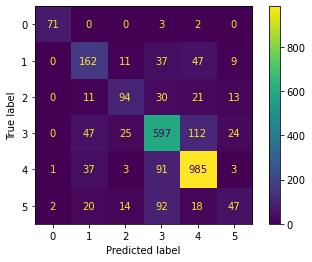

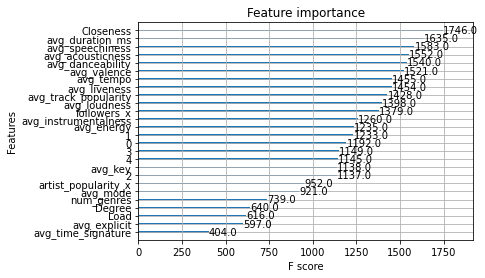

In [409]:
predict_ML(X_train,y_train,X_test, y_test)

# Graph Neural Networks

In [317]:
X_test

,followers_x,artist_popularity_x,num_genres,avg_track_popularity,avg_duration_ms,avg_explicit,avg_danceability,avg_energy,avg_key,avg_loudness,avg_mode,avg_speechiness,avg_acousticness,avg_instrumentalness,avg_liveness,avg_valence,avg_tempo,avg_time_signature
artist_id,,,,,,,,,,,,,,,,,,
5aIqB5nVVvmFsvSdExz408,3149269.0,81,4.0,14.235644,199935.186634,0.000000,0.338852,0.188148,5.192079,-21.045554,0.557921,0.049283,0.944546,6.258070e-01,0.175126,0.485832,103.932328,3.663861
4KISID3Bz7BY5rlKomzYvg,33017.0,37,2.0,35.500000,202980.166667,0.000000,0.799000,0.917833,4.833333,-2.909667,0.333333,0.077650,0.074617,6.719500e-04,0.119500,0.828333,135.829667,4.000000
0lI3rF4hi4op6UxqlLHPzv,656373.0,69,3.0,52.703704,234763.481481,0.407407,0.560741,0.700519,5.111111,-6.244481,0.444444,0.107589,0.129135,3.146778e-05,0.222959,0.385993,126.852593,4.000000
7lKk7yXNockkDjhb1GCeOy,17232.0,57,5.0,57.500000,166681.750000,1.000000,0.787000,0.530000,1.750000,-8.526250,0.250000,0.200500,0.250675,7.745000e-06,0.218500,0.554500,136.007250,4.000000
7moMwCf6s2SVquYO0rrlR8,64132.0,44,3.0,41.833333,201225.500000,0.000000,0.749000,0.732500,4.166667,-4.389333,1.000000,0.077417,0.127467,3.674500e-05,0.096483,0.597500,119.182833,4.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3r0OeTcOw37N9juMYyyw39,218310.0,58,5.0,50.600000,282705.000000,0.800000,0.738600,0.768400,2.600000,-6.471600,1.000000,0.270000,0.294800,3.380000e-07,0.134960,0.815200,90.434600,4.000000
02qHcQfJCm2XlAnaJ5a6Rh,119679.0,67,2.0,63.000000,262733.400000,0.400000,0.562800,0.637000,7.400000,-7.981400,0.400000,0.219800,0.261840,6.072000e-05,0.206800,0.300000,118.697000,3.400000
3lDTgudSVNR05wyiJ1RptF,3186.0,40,1.0,44.500000,195732.000000,0.000000,0.615000,0.658500,7.500000,-7.074500,0.500000,0.167950,0.288500,0.000000e+00,0.181500,0.796500,110.197500,4.000000


Edge index has to be in format [2, num edges]

In [160]:
X.drop('name_x', inplace = True, axis = 1)

In [165]:
X = X.fillna(0)

In [166]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8762 entries, 003f4bk13c6Q3gAUXv7dGJ to 7mOe6jfxX9EILXET9l5L6H
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   followers_x           8762 non-null   float64
 1   artist_popularity_x   8762 non-null   int64  
 2   num_genres            8762 non-null   float64
 3   avg_track_popularity  8762 non-null   float64
 4   avg_duration_ms       8762 non-null   float64
 5   avg_explicit          8762 non-null   float64
 6   avg_danceability      8762 non-null   float64
 7   avg_energy            8762 non-null   float64
 8   avg_key               8762 non-null   float64
 9   avg_loudness          8762 non-null   float64
 10  avg_mode              8762 non-null   float64
 11  avg_speechiness       8762 non-null   float64
 12  avg_acousticness      8762 non-null   float64
 13  avg_instrumentalness  8762 non-null   float64
 14  avg_liveness          8762 non-null   

In [167]:
from torch_geometric.data import Data
from torch_geometric.utils.convert import to_networkx, from_networkx

data = from_networkx(graph)
data.x = X
data.y = y
data.y = torch.tensor(data.y)

Retrieve train and test indices to create the train val test masks for the GNN

In [168]:
train_indices = [id_to_number[idx] for idx in X_train.index]
test_indices = [id_to_number[idx] for idx in X_test.index]

## Architectures

In [169]:
class GCN(torch.nn.Module):
    
    def __init__(self,input_channels,hidden_channels,output_channels):
        super().__init__()
        self.gcnconv1 = GCNConv(input_channels, hidden_channels)
        self.gcnconv2 = GCNConv(hidden_channels,hidden_channels)
        self.gcnconv3 = GCNConv(hidden_channels,output_channels)
        
        self.relu = torch.nn.ReLU()
        
    def forward(self, x,edge_index):
        # no dropout so far
        x = self.relu(self.gcnconv1(x,edge_index))
        x = self.relu(self.gcnconv2(x,edge_index))
        x = F.dropout(x, p=0.2)
        x = self.gcnconv3(x,edge_index)
        return x

In [260]:
class GCN2(torch.nn.Module):
    
    def __init__(self,input_channels,hidden_channels,output_channels):
        super().__init__()
        self.gcnconv1 = GCNConv(input_channels, hidden_channels)
        self.gcnconv2 = GCNConv(hidden_channels,hidden_channels)
        self.gcnconv3 = GCNConv(hidden_channels,hidden_channels)
        self.gcnconv4 = GCNConv(hidden_channels,hidden_channels)
        self.gcnconv5 = GCNConv(hidden_channels,hidden_channels)
        self.gcnconv6 = GCNConv(hidden_channels,output_channels)
        
        self.relu = torch.nn.ReLU()
        
    def forward(self, x,edge_index):
        # no dropout so far
        x = self.relu(self.gcnconv1(x,edge_index))
        x = self.relu(self.gcnconv2(x,edge_index))
        x = self.relu(self.gcnconv3(x,edge_index))
        x = self.relu(self.gcnconv4(x,edge_index))
        x = self.relu(self.gcnconv5(x,edge_index))
        x = F.dropout(x, p=0.5)
        x = self.gcnconv6(x,edge_index)
        return x

In [170]:
import torch_geometric.nn as graphnn


class GAT(nn.Module):
      def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
      
        self.gat1 = graphnn.GATv2Conv(input_size, hidden_size, heads = 4)
        self.lin1 = torch.nn.Linear(input_size, 4 * hidden_size)
        self.gat2 = graphnn.GATv2Conv(hidden_size*4, hidden_size, heads = 4)
        self.lin2 = torch.nn.Linear(4 * hidden_size, 4*hidden_size)
        self.gat3 = graphnn.GATv2Conv(hidden_size*4, output_size, heads = 6, concat = False)
        self.lin3 = torch.nn.Linear(4 * hidden_size, output_size)
        self.dropout = nn.Dropout()
        self.elu = nn.ELU()

      
      def forward(self, x, edge_index):
        x1 = self.gat1(x, edge_index) + self.lin1(x)
        x1 = self.elu(x1)
        x2 = self.gat2(x1, edge_index) + self.lin2(x1)
        x2 = self.elu(x2)
        x2 = F.dropout(x2,p=0.5)
        x3 = self.gat3(x2, edge_index) + (self.lin3(x2))
        return x3

In [216]:
def train_val_test_split(data, train_indices, test_indices):
    # dataset size
    N = len(data.y)
    # we also want a validation set of 10% of the total dataset
    val_size = math.floor(N/10)
    print(val_size)
    
    val_indices = np.random.choice(train_indices,size = val_size, replace = False)
    train_indices = np.sort(np.setdiff1d(train_indices,val_indices))
    # obtain all indices in the dataset
    dataset_indices = torch.arange(N)
    train_mask = torch.isin(dataset_indices,torch.from_numpy(train_indices))
    val_mask = torch.isin(dataset_indices,torch.from_numpy(val_indices))
    test_mask = torch.isin(dataset_indices,torch.from_numpy(test_indices))
    
    return train_mask, val_mask, test_mask, val_indices
    
# Split the data based on the train_test split made before
y_train = pd.Series(y_train)
y_test = pd.Series(y_test)
train_mask, val_mask, test_mask, val_indices = train_val_test_split(data, np.sort(np.array(y_train.index)),np.sort(np.array(y_test.index)))

876


We need our X to have numeric indices

In [173]:
X =  X.merge(pd.DataFrame.from_dict(id_to_number, orient = 'index', columns = ['ID']), how = 'left',left_index = True, right_index = True)
X = X.set_index('ID')
normalized_df=(X-X.mean())/X.std()
data.x = torch.tensor(normalized_df.values)

In [251]:
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay

def train(model, edge_index, x, labels, num_epochs, criterion, optimizer, train_mask, val_mask, test_mask):
    best_val_f1 = 0
    model.train()

    
    for epoch in range(num_epochs):
        # Forward pass for all nodes
        pred = model(x.float(), edge_index)
        # Compute loss on training set: cross entropy loss requires class indices as long
        # and logits (non normalized) as floats
        train_loss = criterion(pred[train_mask].type(torch.float64), labels[train_mask].type(torch.long))
        val_loss = criterion(pred[val_mask].type(torch.float64), labels[val_mask].type(torch.long))
        # Compute accuracy on training/validation/test
        pred = torch.argmax(pred, dim=1)
        train_f1 = f1_score(labels[train_mask].numpy(),pred[train_mask].numpy(), average = 'macro')
        val_f1 = f1_score(labels[val_mask].numpy(),pred[val_mask].numpy(), average = 'macro')
        # Save the best validation accuracy and the corresponding test accuracy.
        if best_val_f1 < val_f1:
            best_val_f1 = val_f1

        # Backward
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        scheduler.step()

        if epoch % 100 == 0:
            print('Epoch {}: train loss {:.3f}, val loss {:.3f} ,train F1: {:.3f}, val F1: {:.3f}'.format(
                epoch, train_loss, val_loss,train_f1, val_f1))

    

def test(model, edge_index, x, labels, test_mask):
    model.eval()
    out = model(x.float(), edge_index)
    # make this F1-score
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    print(pred[test_mask])
    print(labels[test_mask])
    test_correct = pred[test_mask] == labels[test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(test_mask.sum())  # Derive ratio of correct predictions.
    macro_f1 = f1_score(labels[test_mask].numpy(),pred[test_mask].numpy(), average = 'macro')
    print(f'Test accuracy: {test_acc} and  test macro: {macro_f1}')
    #print(confusion_matrix(labels[val_mask].numpy(),pred[val_mask].numpy(), normalize = 'true'))
    #print(confusion_matrix(labels[val_mask].numpy(),pred[val_mask].numpy()))
    disp = ConfusionMatrixDisplay(confusion_matrix(labels[test_mask].numpy(),pred[test_mask].numpy()), display_labels = le.classes_)
    disp.plot()


At the moment, it predicts all four => majority class

In [190]:
from sklearn.utils.class_weight import compute_class_weight

weights = compute_class_weight('balanced',classes =  np.unique(y),y= y)
weights

array([5.8647925 , 1.60829662, 2.45022371, 0.55844487, 0.39214107,
       2.17960199])

In [233]:
torch.autograd.set_detect_anomaly(True)
hidden_size = 64
lr = 0.01
class_weight = weights
weight_decay = 0.0005
#class_weight = [np.array([0.1,0.8])]
model = GAT(data.x.shape[1], hidden_size,6)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay = weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 400, gamma=0.1)
criterion = torch.nn.CrossEntropyLoss(weight = torch.from_numpy(class_weight))
num_epochs = 1000
train(model, data.edge_index, data.x, data.y, num_epochs, criterion, optimizer, train_mask, val_mask, test_mask)  

Epoch 0: train loss 2.396, val loss 2.432 ,train F1: 0.094, val F1: 0.098
Epoch 100: train loss 0.714, val loss 0.768 ,train F1: 0.674, val F1: 0.660
Epoch 200: train loss 0.586, val loss 0.710 ,train F1: 0.729, val F1: 0.719
Epoch 300: train loss 0.508, val loss 0.651 ,train F1: 0.755, val F1: 0.724
Epoch 400: train loss 0.440, val loss 0.664 ,train F1: 0.789, val F1: 0.725
Epoch 500: train loss 0.435, val loss 0.660 ,train F1: 0.793, val F1: 0.721
Epoch 600: train loss 0.429, val loss 0.700 ,train F1: 0.794, val F1: 0.723
Epoch 700: train loss 0.420, val loss 0.737 ,train F1: 0.802, val F1: 0.735
Epoch 800: train loss 0.417, val loss 0.716 ,train F1: 0.799, val F1: 0.719
Epoch 900: train loss 0.414, val loss 0.720 ,train F1: 0.808, val F1: 0.719


In [ ]:
torch.autograd.set_detect_anomaly(True)
hidden_size = 64
lr = 0.001
class_weight = weights
weight_decay = 0.0005
#class_weight = [np.array([0.1,0.8])]
model = GAT(data.x.shape[1], hidden_size,6)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 400, gamma=0.1)
criterion = torch.nn.CrossEntropyLoss()
num_epochs = 500
train(model, data.edge_index, data.x, data.y, num_epochs, criterion, optimizer, train_mask, val_mask, test_mask)  

tensor([0, 0, 0,  ..., 5, 1, 1])
tensor([0, 0, 0,  ..., 5, 4, 1])
Test accuracy: 0.9440852034994295 and  test macro: 0.9170026592316547


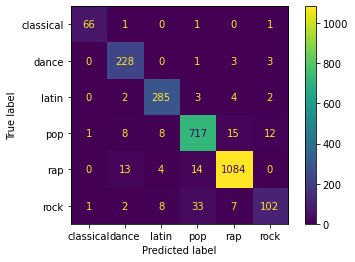

In [257]:
test(model, data.edge_index, data.x, data.y, test_mask)

In [258]:
torch.autograd.set_detect_anomaly(True)
hidden_size = 128
lr = 0.01
class_weight = weights
weight_decay = 0.0005
#class_weight = [np.array([0.1,0.8])]
model = GCN(data.x.shape[1], hidden_size,6)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 400, gamma=0.1)
criterion = torch.nn.CrossEntropyLoss(weight = torch.from_numpy(class_weight))
num_epochs = 1000
train(model, data.edge_index, data.x, data.y, num_epochs, criterion, optimizer, train_mask, val_mask, test_mask) 

Epoch 0: train loss 1.819, val loss 1.847 ,train F1: 0.079, val F1: 0.080
Epoch 100: train loss 0.438, val loss 0.725 ,train F1: 0.764, val F1: 0.712
Epoch 200: train loss 0.342, val loss 0.882 ,train F1: 0.813, val F1: 0.710
Epoch 300: train loss 0.284, val loss 1.033 ,train F1: 0.840, val F1: 0.721
Epoch 400: train loss 0.248, val loss 1.128 ,train F1: 0.857, val F1: 0.724
Epoch 500: train loss 0.238, val loss 1.133 ,train F1: 0.863, val F1: 0.728
Epoch 600: train loss 0.233, val loss 1.169 ,train F1: 0.865, val F1: 0.738
Epoch 700: train loss 0.226, val loss 1.195 ,train F1: 0.861, val F1: 0.727
Epoch 800: train loss 0.223, val loss 1.201 ,train F1: 0.869, val F1: 0.732
Epoch 900: train loss 0.221, val loss 1.215 ,train F1: 0.867, val F1: 0.728


In [241]:
torch.autograd.set_detect_anomaly(True)
hidden_size = 64
lr = 0.01
class_weight = weights
weight_decay = 0.0005
#class_weight = [np.array([0.1,0.8])]
model = GCN(data.x.shape[1], hidden_size,6)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 400, gamma=0.1)
criterion = torch.nn.CrossEntropyLoss()
num_epochs = 1000
train(model, data.edge_index, data.x, data.y, num_epochs, criterion, optimizer, train_mask, val_mask, test_mask) 

Epoch 0: train loss 1.885, val loss 1.879 ,train F1: 0.057, val F1: 0.061
Epoch 100: train loss 0.553, val loss 0.659 ,train F1: 0.745, val F1: 0.692
Epoch 200: train loss 0.459, val loss 0.671 ,train F1: 0.788, val F1: 0.713
Epoch 300: train loss 0.409, val loss 0.739 ,train F1: 0.812, val F1: 0.707
Epoch 400: train loss 0.378, val loss 0.801 ,train F1: 0.822, val F1: 0.701
Epoch 500: train loss 0.369, val loss 0.819 ,train F1: 0.830, val F1: 0.714
Epoch 600: train loss 0.363, val loss 0.817 ,train F1: 0.824, val F1: 0.705
Epoch 700: train loss 0.356, val loss 0.824 ,train F1: 0.828, val F1: 0.707
Epoch 800: train loss 0.357, val loss 0.849 ,train F1: 0.831, val F1: 0.705
Epoch 900: train loss 0.354, val loss 0.835 ,train F1: 0.833, val F1: 0.717


tensor([0, 0, 0,  ..., 5, 5, 1])
tensor([0, 0, 0,  ..., 5, 4, 1])
Test accuracy: 0.8634461772537086 and  test macro: 0.8559592780994046


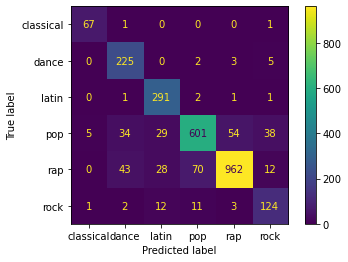

In [259]:
test(model, data.edge_index, data.x, data.y, test_mask)

Oversmoothing? Seemingly not

In [261]:
torch.autograd.set_detect_anomaly(True)
hidden_size = 64
lr = 0.01
class_weight = weights
weight_decay = 0.0005
#class_weight = [np.array([0.1,0.8])]
model = GCN2(data.x.shape[1], hidden_size,6)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 400, gamma=0.1)
criterion = torch.nn.CrossEntropyLoss()
num_epochs = 1000
train(model, data.edge_index, data.x, data.y, num_epochs, criterion, optimizer, train_mask, val_mask, test_mask) 

Epoch 0: train loss 1.805, val loss 1.804 ,train F1: 0.073, val F1: 0.070
Epoch 100: train loss 0.544, val loss 0.684 ,train F1: 0.751, val F1: 0.704
Epoch 200: train loss 0.448, val loss 0.686 ,train F1: 0.793, val F1: 0.709
Epoch 300: train loss 0.415, val loss 0.742 ,train F1: 0.803, val F1: 0.700
Epoch 400: train loss 0.409, val loss 0.966 ,train F1: 0.781, val F1: 0.684
Epoch 500: train loss 0.338, val loss 1.038 ,train F1: 0.842, val F1: 0.709
Epoch 600: train loss 0.329, val loss 1.043 ,train F1: 0.848, val F1: 0.703
Epoch 700: train loss 0.322, val loss 1.075 ,train F1: 0.854, val F1: 0.714
Epoch 800: train loss 0.312, val loss 1.129 ,train F1: 0.857, val F1: 0.704
Epoch 900: train loss 0.311, val loss 1.165 ,train F1: 0.856, val F1: 0.708


tensor([0, 0, 0,  ..., 1, 1, 1])
tensor([0, 0, 0,  ..., 5, 4, 1])
Test accuracy: 0.8702928870292888 and  test macro: 0.8461855605728911


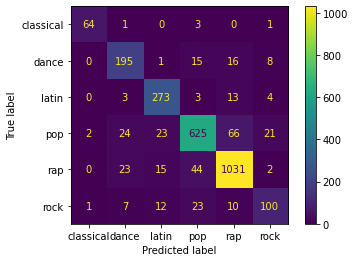

In [263]:
test(model, data.edge_index, data.x, data.y, test_mask)

#### Drawing the graph

In [268]:
def draw_graph(G, with_labels=False, node_size=20, fig_size=(15, 15), colors = None):
    """
    Function that draws a graph.
    """
    fig, ax = plt.subplots(figsize=fig_size)
    ntx.draw_networkx(G, with_labels=with_labels, node_size=node_size, ax=ax, node_color = colors)

In [262]:
colors = y

Drawing the graph based on labels

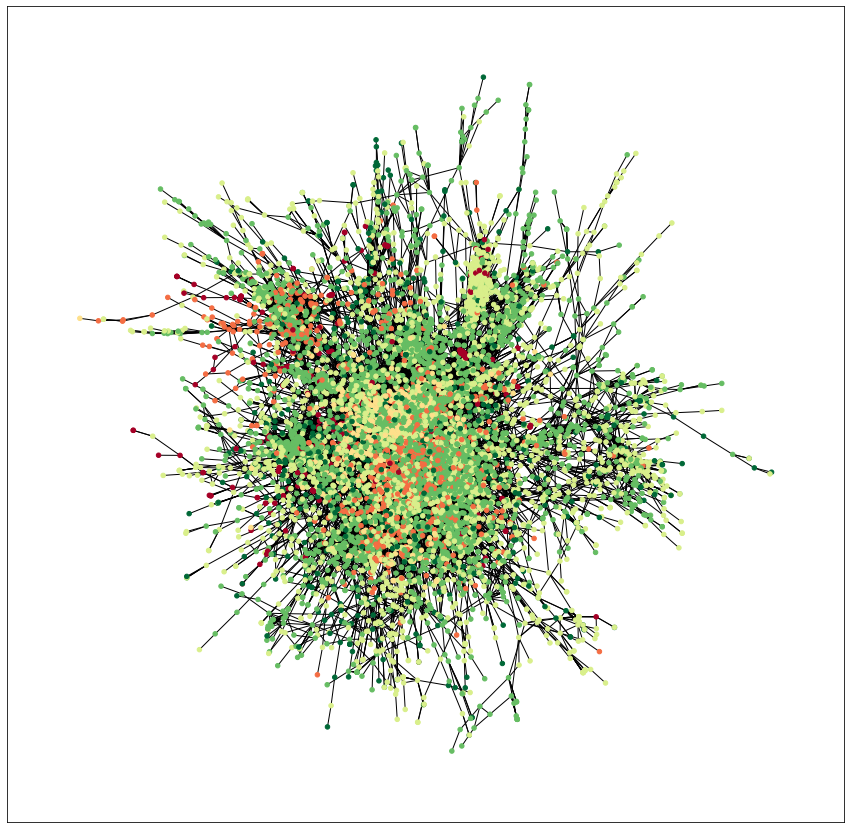

In [270]:
draw_graph(graph, with_labels = False,colors =  colors)

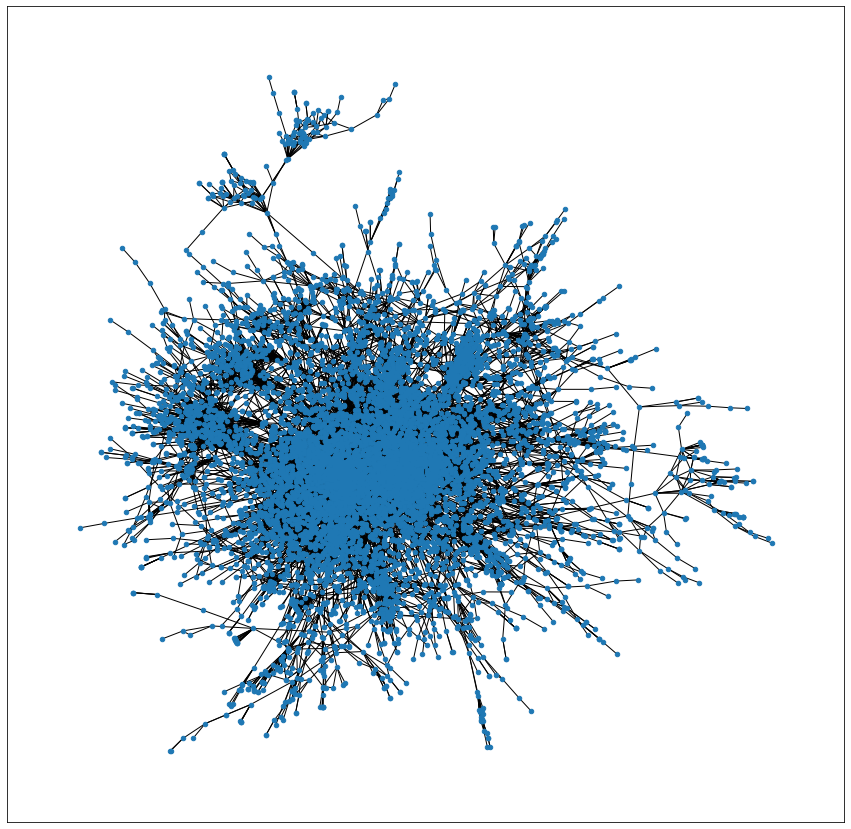

In [12]:
draw_graph(graph)

# Communities

In [271]:
communities = ntx.community.louvain_communities(graph)

How many communities? Seem to be based on nationalities

In [283]:
largest_set = [len(s) for s in communities]
np.argmax(largest_set)

8

In [430]:
artists_600_features.loc[communities[37]]
#.genres.value_counts()

/var/folders/m0/917c7sgx5vzfm6n8cvvnzgmw0000gn/T/ipykernel_53373/524032577.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  artists_600_features.loc[communities[37]]


,followers,genres,name,artist_popularity,num_genres,avg_track_popularity,avg_duration_ms,avg_explicit,avg_danceability,avg_energy,avg_key,avg_loudness,avg_mode,avg_speechiness,avg_acousticness,avg_instrumentalness,avg_liveness,avg_valence,avg_tempo,avg_time_signature
artist_id,,,,,,,,,,,,,,,,,,,,
6e3pZKXUxrPfnUPJ960Hd9,302598.0,"[french indie pop, french pop]",Pomme,65,2,56.1,203566.70,0.0,0.59050,0.5042,5.70,-8.8611,0.2,0.041930,0.656000,3.697634e-02,0.199860,0.3864,111.88740,3.8
4VuZOySa9AIegZZzNIjPLC,24572.0,"[chanson, french indie pop, nouvelle chanson f...",Albin de la Simone,43,3,47.0,216400.00,0.0,0.38300,0.5260,2.00,-12.0470,0.0,0.087200,0.922000,8.130000e-04,0.764000,0.3200,94.82400,3.0
6XJmHR6Q8lIpjx2JukLaQo,16466.0,[french hip hop],Demon One,37,1,40.0,286520.00,0.0,0.59400,0.9195,6.00,-3.8565,0.0,0.212500,0.246500,3.420000e-06,0.166800,0.6255,96.93300,4.0
5p9kx3T4qpQIq88fibnUeN,12972.0,"[french hip hop, rap inde]",Haroun,44,2,47.5,354946.50,0.0,0.75050,0.7770,5.00,-4.9510,0.0,0.337500,0.117500,1.045000e-06,0.281000,0.5745,96.91000,4.0
53ZDw5ZHldHJgaUjcJhdGc,97950.0,"[francoton, french pop]",Léa Castel,52,2,44.5,247948.25,0.0,0.40575,0.6045,6.25,-6.8810,0.0,0.121575,0.187108,1.347500e-06,0.148225,0.2710,131.59425,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7CW7QdOgRStOg7JktRuZ3E,412776.0,"[francoton, pop urbaine]",Imen Es,65,2,61.0,193477.60,0.2,0.66600,0.6198,6.80,-6.8110,0.2,0.094320,0.307600,2.700000e-07,0.165040,0.5538,123.96720,4.2
2fTmTncg0c3LhS5FlERvar,340.0,[old school rap francais],Fat Cap,22,1,33.0,242800.00,1.0,0.78100,0.7940,11.00,-3.6840,0.0,0.348000,0.054000,0.000000e+00,0.107000,0.8580,91.79400,4.0
2OTfhbxhBO1u1bAuCy6ouu,118664.0,"[french hip hop, pop urbaine, rap calme, rap f...",Deen Burbigo,54,5,53.0,195620.00,1.0,0.85300,0.5270,4.00,-8.4620,0.5,0.162500,0.511500,0.000000e+00,0.133500,0.4425,133.46800,4.0
